In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from datetime import datetime

from model_settings import ms
from feature_collector import collect_features, preprocess_data

os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)

# initializing

In [2]:
from convsklearn import barrier_trainer, asian_trainer
price_name = 'asian' 
filetag = 'bloomberg asians'
trainer = asian_trainer
datadir = os.path.join(root,ms.bloomberg_spx_asians['dump'])

dataset = collect_features(datadir,price_name)
dates = pd.Series(np.sort(dataset['calculation_date'].unique()))

train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")
dates

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1511/1511 [00:11<00:00, 137.26it/s]



##################
# training start #
##################

Fri Nov  1 20:53:34 2024



0      2007-01-03
1      2007-01-04
2      2007-01-05
3      2007-01-08
4      2007-01-09
          ...    
1505   2012-12-24
1506   2012-12-26
1507   2012-12-27
1508   2012-12-28
1509   2012-12-31
Length: 1510, dtype: datetime64[ns]

# preprocessing

## train/test split

[]

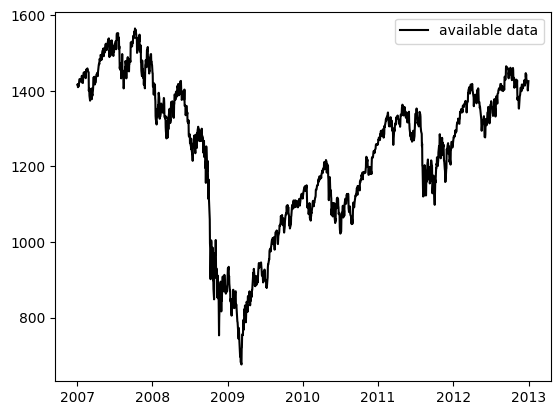

In [3]:
plt.figure()
plt.plot(dataset[['spot_price','calculation_date']].copy().drop_duplicates().set_index('calculation_date'),color='black',label='available data')
plt.legend()
plt.plot()

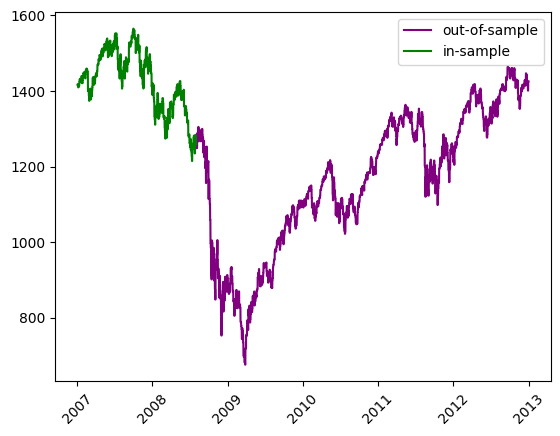

In [4]:
# development_dates = dates[:len(dates)//4]
development_dates = dates[dates<=pd.Timestamp(2008,8,1)]
test_dates = dates[~dates.isin(development_dates)]
preprocessed = preprocess_data(dataset,development_dates,test_dates,trainer)
train_test = preprocessed['train_test_arrays']
preprocessor = preprocessed['preprocessor']
train_X=train_test['train_X']
train_y=train_test['train_y']
test_X=train_test['test_X']
test_y=train_test['test_y']
train_data = preprocessed['train_data']
test_data = preprocessed['test_data']

In [5]:
model_fit = trainer.run_dnn(preprocessor,train_X,train_y)
train_test = trainer.test_prediction_accuracy(train_data,test_data,model_fit)
train_data = train_test['train_data']
test_data = train_test['test_data']


training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 21.49611759185791

in sample:
     RMSE: 2.7302249764187825
     MAE: 1.6727071898536907

out of sample:
     RMSE: 18.04153800709517
     MAE: 7.516311830927597


# saving

In [6]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    n_calls = train_data[train_data['w']=='call'].shape[0]
    n_puts = train_data[train_data['w']=='put'].shape[0]
    train_data.to_csv(f"{file_dir} train_data.csv")
    test_data.to_csv(f"{file_dir} test_data.csv")
    joblib.dump(model_fit,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_01 205356527985 bloomberg asians

cpu: 22.438588619232178
